# Mean climate evaluation

This analysis compares the mean climate of downscaled and parent models to observations. It doesn't consider extremes (i.e. the tails of the distribution aren't considered).

In [9]:
import glob

import xarray as xr
import numpy as np
import xesmf as xe
import dask.diagnostics
import geopandas as gp

import spatial_selection
import plotting

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
dask.diagnostics.ProgressBar().register()

In [12]:
start_date = '1995-01-01'
end_date = '2014-12-31'

In [13]:
aus_shape = gp.read_file('/g/data/xv83/dbi599/shapefiles/australia/australia.shp')

## AGCD data

In [14]:
agcd_years = np.arange(1995, 2015, 1)
agcd_pr_files = [f'/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_{year}.nc' for year in agcd_years]
agcd_pr_files

['/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1995.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1996.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1997.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1998.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1999.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_2000.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_2001.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_2002.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_2003.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_2004.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthl

In [15]:
agcd_ds = xr.open_mfdataset(agcd_pr_files)
agcd_ds = agcd_ds.sel({'time': slice(start_date, end_date)})

In [16]:
agcd_annual_totals = agcd_ds.resample({'time': 'A'}).sum('time', keep_attrs=True)
agcd_annual_clim = agcd_annual_totals.mean('time', keep_attrs=True)
agcd_monthly_clim = agcd_ds.groupby('time.month').mean('time', keep_attrs=True)

In [17]:
agcd_annual_clim = spatial_selection.select_shapefile_regions(agcd_annual_clim, aus_shape)

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  8.4s
[########################################] | 100% Completed |  8.5s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  3.7s
[########################################] | 100% Completed |  3.8s


In [18]:
agcd_monthly_clim = spatial_selection.select_shapefile_regions(agcd_monthly_clim, aus_shape)

[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  1.4s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  1.6s
[########################################] | 100% Completed |  3.8s
[########################################] | 100% Completed |  3.8s


## Parent model data

In [19]:
parent_files = {}
parent_files['NorESM2-MM'] = [
    '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_19900101-19991231.nc',
    '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_20000101-20091231.nc',
    '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_20100101-20141231.nc'
]
parent_files['ACCESS-CM2'] = [
    '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r4i1p1f1/day/pr/gn/latest/pr_day_ACCESS-CM2_historical_r4i1p1f1_gn_19500101-19991231.nc',
    '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r4i1p1f1/day/pr/gn/latest/pr_day_ACCESS-CM2_historical_r4i1p1f1_gn_20000101-20141231.nc'
]

In [20]:
def read_model_pr_data(file_list, obs_ds, aus_shape, time_bounds=None):
    """Read model precipitation data and calculate annual and monthly climatology"""
    
    ds = xr.open_mfdataset(file_list)
    if time_bounds:
        start_date, end_date = time_bounds
        ds = ds.sel({'time': slice(start_date, end_date)})
    ds['pr'] = ds['pr'] * 86400
    ds['pr'].attrs['units'] = 'mm'
    
    annual_totals = ds.resample({'time': 'A'}).sum('time', keep_attrs=True)
    annual_clim = annual_totals.mean('time', keep_attrs=True)
    monthly_totals = ds.resample({'time': 'M'}).sum('time', keep_attrs=True)
    monthly_clim = monthly_totals.groupby('time.month').mean('time', keep_attrs=True)
    
    regridder = xe.Regridder(ds, obs_ds, "bilinear")
    annual_clim = regridder(annual_clim)
    monthly_clim = regridder(monthly_clim)
    
    annual_clim = spatial_selection.select_shapefile_regions(annual_clim, aus_shape)
    monthly_clim = spatial_selection.select_shapefile_regions(monthly_clim, aus_shape)
    
    annual_clim = annual_clim.compute()
    monthly_clim = monthly_clim.compute()
    
    return monthly_clim, annual_clim

In [21]:
annual_clim_dict = {}
monthly_clim_dict = {}

for model in ['NorESM2-MM', 'ACCESS-CM2']:
    monthly_clim_dict[model], annual_clim_dict[model] = read_model_pr_data(
        parent_files[model], agcd_ds, aus_shape, time_bounds=[start_date, end_date],
    )

[########################################] | 100% Completed | 24.1s
[########################################] | 100% Completed | 24.2s
[########################################] | 100% Completed | 11.6s
[########################################] | 100% Completed | 11.6s
[########################################] | 100% Completed | 12.5s
[########################################] | 100% Completed | 12.6s
[########################################] | 100% Completed | 12.1s
[########################################] | 100% Completed | 12.2s
[########################################] | 100% Completed | 11.7s
[########################################] | 100% Completed | 11.7s
[########################################] | 100% Completed | 12.3s
[########################################] | 100% Completed | 12.3s
[########################################] | 100% Completed | 13.7s
[########################################] | 100% Completed | 13.8s
[########################################] | 100

## RCM data

In [22]:
rcm_files = {}

rcm_files['BARPA'] = glob.glob('/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/pr/*.nc')
rcm_files['BARPA'].sort()
rcm_files['BARPA']

['/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/pr/pr_AUS-17i_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_day_19800101-19801231.nc',
 '/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/pr/pr_AUS-17i_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_day_19810101-19811231.nc',
 '/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/pr/pr_AUS-17i_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_day_19820101-19821231.nc',
 '/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/pr/pr_AUS-17i_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_day_19830101-19831231.nc',
 '/g/data/tp28/ACS_DRS_v0.3/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/pr/pr_AUS-17

In [23]:
for model in ['BARPA']:
    monthly_clim_dict[model], annual_clim_dict[model] = read_model_pr_data(
        rcm_files[model], agcd_ds, aus_shape,
    )

[########################################] | 100% Completed |  1min 21.3s
[########################################] | 100% Completed |  1min 21.4s
[########################################] | 100% Completed | 33.7s
[########################################] | 100% Completed | 33.8s
[########################################] | 100% Completed | 27.9s
[########################################] | 100% Completed | 27.9s
[########################################] | 100% Completed | 27.6s
[########################################] | 100% Completed | 27.7s
[########################################] | 100% Completed | 27.2s
[########################################] | 100% Completed | 27.3s
[########################################] | 100% Completed | 27.5s
[########################################] | 100% Completed | 27.6s


## Mean bias

In [24]:
agcd_annual_clim = agcd_annual_clim.compute()

[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  4.2s


/g/data/xv83/dbi599/model-evaluation/pr_annual-clim_CCAM-NorESM2-MM_1995-01-01_2014-12-31.png


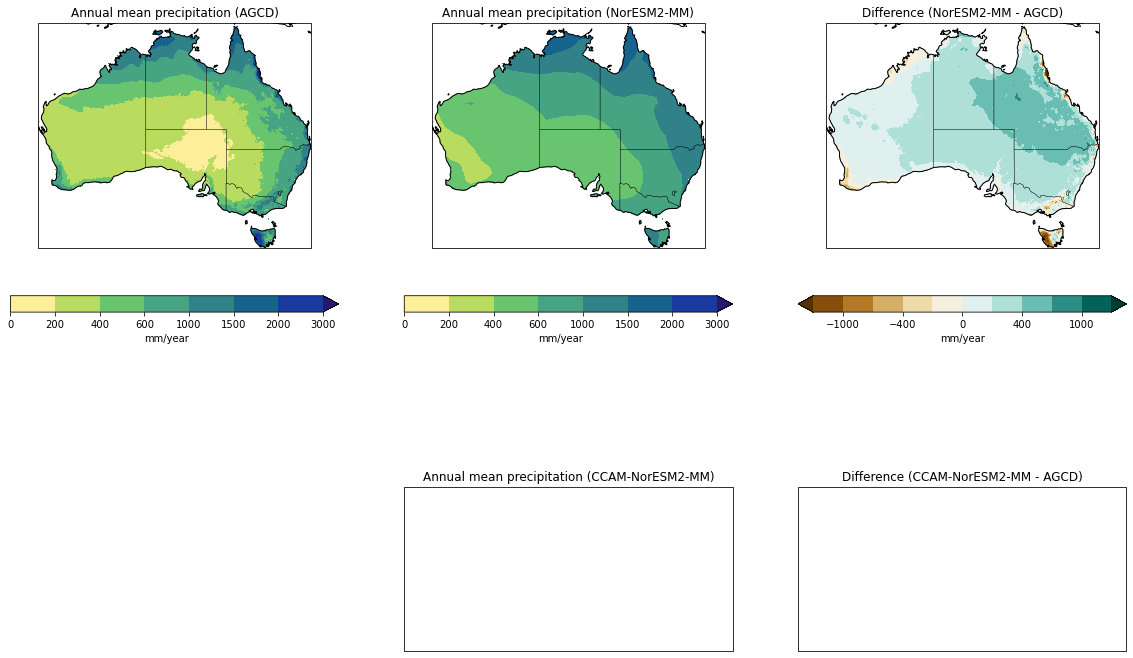

In [25]:
plotting.compare_agcd_gcm_rcm(
    agcd_annual_clim['precip'],
    annual_clim_dict['NorESM2-MM']['pr'],
    'pr',
    'annual-clim',
    'NorESM2-MM',
    'CCAM',
    start_date,
    end_date,
    [0, 200, 400, 600, 1000, 1500, 2000, 3000],
    [-1500, -1000, -600, -400, -200, 0, 200, 400, 600, 1000, 1500],
    rcm_da=None,
)

/g/data/xv83/dbi599/model-evaluation/pr_annual-clim_BARPA-ACCESS-CM2_1995-01-01_2014-12-31.png


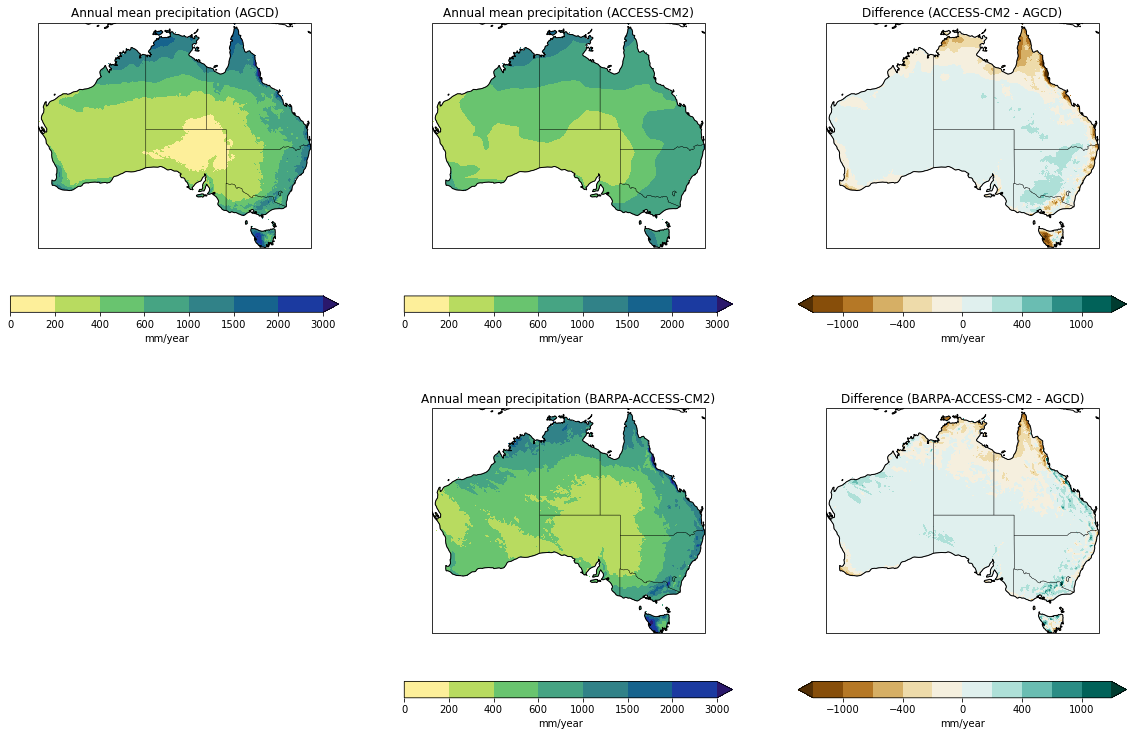

In [26]:
plotting.compare_agcd_gcm_rcm(
    agcd_annual_clim['precip'],
    annual_clim_dict['ACCESS-CM2']['pr'],
    'pr',
    'annual-clim',
    'ACCESS-CM2',
    'BARPA',
    start_date,
    end_date,
    [0, 200, 400, 600, 1000, 1500, 2000, 3000],
    [-1500, -1000, -600, -400, -200, 0, 200, 400, 600, 1000, 1500],
    rcm_da=annual_clim_dict['BARPA']['pr'],
)

## Temporal 

In [27]:
agcd_monthly_clim = agcd_monthly_clim.compute()

[########################################] | 100% Completed |  6.3s
[########################################] | 100% Completed |  6.4s


/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/g/data/xv83/dbi599/model-evaluation/pr_seasonal-cycle_CCAM-NorESM2-MM_1995-01-01_2014-12-31.png


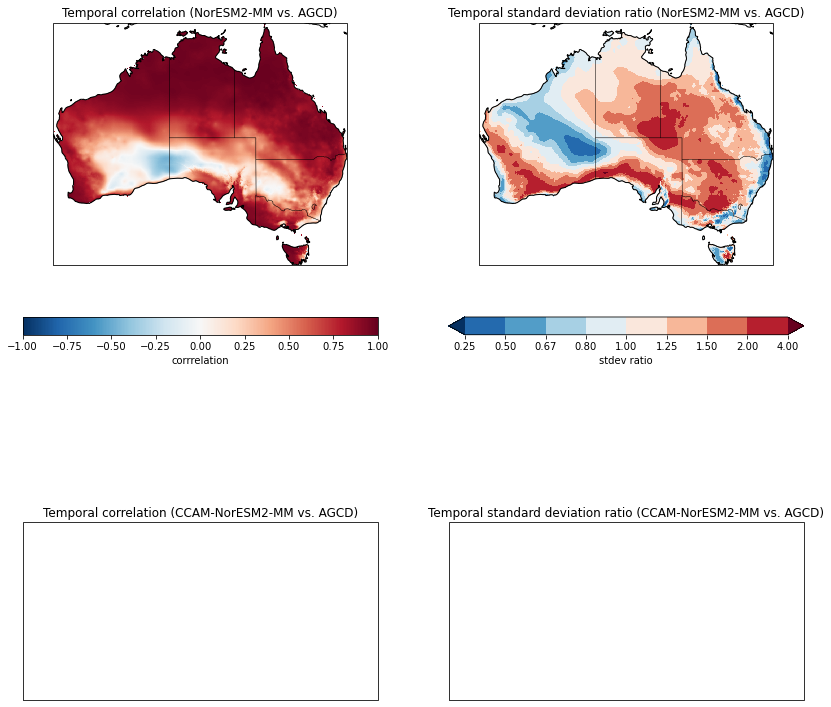

In [28]:
plotting.temporal_evaluation(
    monthly_clim_dict['NorESM2-MM']['pr'],
    agcd_monthly_clim['precip'],
    'pr',
    'NorESM2-MM',
    'CCAM',
    start_date,
    end_date,
)

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeW

/g/data/xv83/dbi599/model-evaluation/pr_seasonal-cycle_BARPA-ACCESS-CM2_1995-01-01_2014-12-31.png


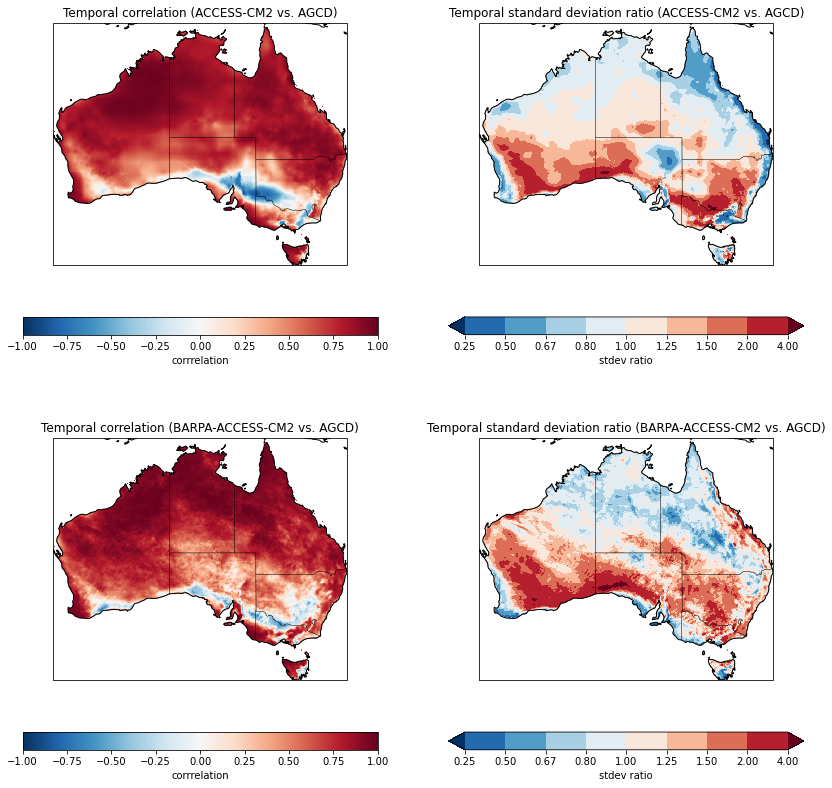

In [29]:
plotting.temporal_evaluation(
    monthly_clim_dict['ACCESS-CM2']['pr'],
    agcd_monthly_clim['precip'],
    'pr',
    'ACCESS-CM2',
    'BARPA',
    start_date,
    end_date,
    rcm_monthly_clim=monthly_clim_dict['BARPA']['pr'],
)

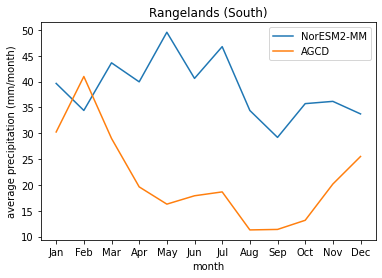

In [30]:
plotting.seasonal_cycle(
    monthly_clim_dict['NorESM2-MM']['pr'],
    agcd_monthly_clim['precip'],
    'NorESM2-MM',
    cluster_name='Rangelands (South)'
)

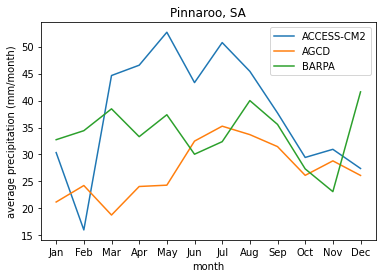

In [31]:
plotting.seasonal_cycle(
    monthly_clim_dict['ACCESS-CM2']['pr'],
    agcd_monthly_clim['precip'],
    'ACCESS-CM2',
    rcm_monthly_clim=monthly_clim_dict['BARPA']['pr'],
    rcm_name='BARPA',
    latlon_point=[-35.261, 140.905],
    latlon_name='Pinnaroo, SA'
)

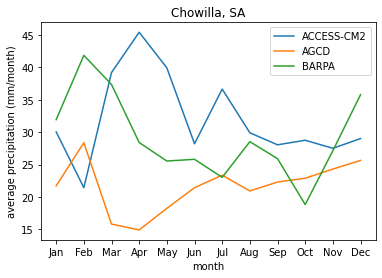

In [32]:
plotting.seasonal_cycle(
    monthly_clim_dict['ACCESS-CM2']['pr'],
    agcd_monthly_clim['precip'],
    'ACCESS-CM2',
    rcm_monthly_clim=monthly_clim_dict['BARPA']['pr'],
    rcm_name='BARPA',
    latlon_point=[-33.661, 140.941],
    latlon_name='Chowilla, SA'
)

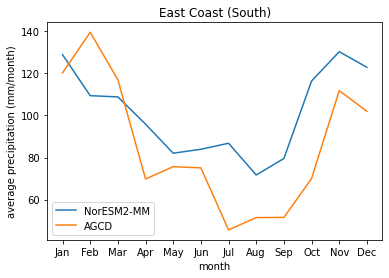

In [33]:
plotting.seasonal_cycle(
    monthly_clim_dict['NorESM2-MM']['pr'],
    agcd_monthly_clim['precip'],
    'NorESM2-MM',
    cluster_name='East Coast (South)',
)

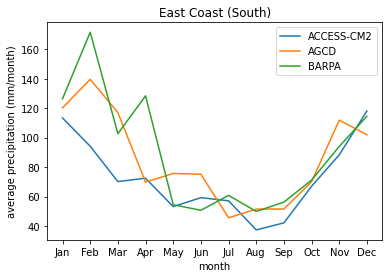

In [34]:
plotting.seasonal_cycle(
    monthly_clim_dict['ACCESS-CM2']['pr'],
    agcd_monthly_clim['precip'],
    'ACCESS-CM2',
    rcm_monthly_clim=monthly_clim_dict['BARPA']['pr'],
    rcm_name='BARPA',
    cluster_name='East Coast (South)'
)

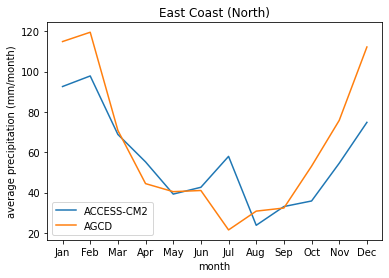

In [35]:
plotting.seasonal_cycle(
    monthly_clim_dict['ACCESS-CM2']['pr'],
    agcd_monthly_clim['precip'],
    'ACCESS-CM2',
    cluster_name='East Coast (North)',
)